## 1. Import thư viện và cấu hình

In [18]:
import os
import sys
import torch
import numpy as np
from pathlib import Path
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Thêm đường dẫn để import mmdet
sys.path.insert(0, '/home/coder/data/trong/KLTN/DETR_Mixup/MixPL')

from mmengine.config import Config
from mmengine.runner import Runner
from mmdet.apis import init_detector, inference_detector
from mmdet.utils import register_all_modules
from mmdet.registry import VISUALIZERS

# Register all modules
register_all_modules()

## 2. Thiết lập đường dẫn

In [19]:
# Đường dẫn tới config file
config_file = '/home/coder/data/trong/KLTN/DETR_Mixup/MixPL/projects/MixPL/configs/mixpl_coco_r50_custom_40.py'

# Đường dẫn tới checkpoint
checkpoint_file = '/home/coder/data/trong/KLTN/DETR_Mixup/MixPL/projects/MixPL/work_dirs/mixpl_coco_r50_custom_40/iter_60000.pth'

# Device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

print(f"Config: {config_file}")
print(f"Checkpoint: {checkpoint_file}")
print(f"Device: {device}")

Config: /home/coder/data/trong/KLTN/DETR_Mixup/MixPL/projects/MixPL/configs/mixpl_coco_r50_custom_40.py
Checkpoint: /home/coder/data/trong/KLTN/DETR_Mixup/MixPL/projects/MixPL/work_dirs/mixpl_coco_r50_custom_40/iter_60000.pth
Device: cpu


## 3. Load config và kiểm tra

In [20]:
# Load config
cfg = Config.fromfile(config_file)

# Kiểm tra số classes
num_classes = cfg.model.detector.bbox_head.num_classes
print(f"Number of classes: {num_classes}")

# Class names (tùy chỉnh theo dataset của bạn)
class_names = ['Broken', 'Chipped', 'Scratched', 'Severe_Rust', 'Tip_Wear']  # Thay đổi theo dataset
print(f"Classes: {class_names}")

Number of classes: 5
Classes: ['Broken', 'Chipped', 'Scratched', 'Severe_Rust', 'Tip_Wear']


## 4. Khởi tạo model

In [21]:
# Build the model from config and load checkpoint
# Với MixPL, cần load model theo cách khác vì nó là semi-supervised framework
from mmengine.runner import load_checkpoint

# Load config
cfg = Config.fromfile(config_file)

# Build model
from mmdet.registry import MODELS
model = MODELS.build(cfg.model)

# Load checkpoint
checkpoint = load_checkpoint(model, checkpoint_file, map_location=device)

# Thêm cfg vào model để inference_detector hoạt động
model.cfg = cfg

# Set model to eval mode
model.eval()
model.to(device)

print("Model loaded successfully!")
print(f"Model type: {type(model)}")
print(f"Model on device: {next(model.parameters()).device}")

Loads checkpoint by local backend from path: /home/coder/data/trong/KLTN/DETR_Mixup/MixPL/projects/MixPL/work_dirs/mixpl_coco_r50_custom_40/iter_60000.pth
Model loaded successfully!
Model type: <class 'projects.MixPL.mixpl.mixpl.MixPL'>
Model on device: cpu


In [22]:
# Tạo hàm inference cho MixPL
def inference_mixpl(model, img_path):
    """
    Inference wrapper cho MixPL model
    """
    from mmdet.apis import inference_detector
    
    # MixPL sử dụng teacher model để inference
    # Lấy detector từ model (có thể là student hoặc teacher)
    if hasattr(model, 'semi_test_cfg') and model.semi_test_cfg.get('predict_on') == 'teacher':
        # Sử dụng teacher model
        inference_model = model.teacher if hasattr(model, 'teacher') else model.detector
    else:
        # Sử dụng student model
        inference_model = model.detector if hasattr(model, 'detector') else model
    
    # Thêm cfg nếu chưa có
    if not hasattr(inference_model, 'cfg'):
        inference_model.cfg = model.cfg
    
    # Run inference
    result = inference_detector(inference_model, img_path)
    return result

print("Inference function created!")

Inference function created!


## 5. Hàm visualize kết quả

In [29]:
def visualize_result(img_path, result, score_thr=0.3, class_names=None):
    """
    Visualize detection results and optionally return the drawn image as numpy array.
    """
    # Read image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_draw = img.copy()

    # Get predictions
    pred_instances = result.pred_instances
    bboxes = pred_instances.bboxes.cpu().numpy()
    scores = pred_instances.scores.cpu().numpy()
    labels = pred_instances.labels.cpu().numpy()

    # Filter by threshold
    valid_idx = scores >= score_thr
    bboxes = bboxes[valid_idx]
    scores = scores[valid_idx]
    labels = labels[valid_idx]

    # Colors mapped to classes
    colors = [
        (134, 34, 255),   # Broken
        (0, 255, 206),    # Chipped
        (199, 252, 0),    # Scratched
        (254, 0, 86),     # Severe_Rust
        (255, 128, 0),    # Tip_Wear
    ]

    # Draw boxes on img_draw
    for bbox, score, label in zip(bboxes, scores, labels):
        x1, y1, x2, y2 = bbox.astype(int)
        print(int(label))
        color = colors[int(label)]

        # Draw rectangle
        cv2.rectangle(img_draw, (x1, y1), (x2, y2), color, 2)

        # Label text
        label_text = f'{class_names[int(label)] if class_names else int(label)}: {score:.2f}'
        cv2.putText(img_draw, label_text, (x1, max(0, y1 - 5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Show image
    plt.figure(figsize=(12, 8))
    plt.imshow(img_draw)
    plt.axis('off')
    plt.show()

    # Print summary
    print(f"\nDetected {len(bboxes)} objects with score >= {score_thr}:")
    for i, (bbox, score, label) in enumerate(zip(bboxes, scores, labels)):
        class_name = class_names[int(label)] if class_names else f"Class {int(label)}"
        print(f"  {i+1}. {class_name}: {score:.3f} - bbox: {bbox}")

    return img_draw

## 6. Inference trên một ảnh

Testing on: /home/coder/data/trong/KLTN/data_drill_3/test/S234_Image__2025-11-05__14-57-15_dark_3_crop_5_jpg.rf.9f2c4553eefb260b1a85812234815131.jpg


3
1
3


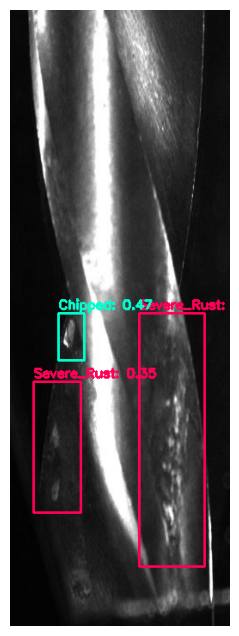


Detected 3 objects with score >= 0.3:
  1. Severe_Rust: 0.879 - bbox: [150.85597 354.6549  226.56587 650.30084]
  2. Chipped: 0.468 - bbox: [ 56.640106 354.27173   86.03409  409.5983  ]
  3. Severe_Rust: 0.350 - bbox: [ 27.234451 434.32022   82.63553  587.91364 ]
Saved: S234_Image__2025-11-05__14-57-15_dark_3_crop_5_jpg.jpg


In [40]:
# Đường dẫn tới ảnh test (thay đổi theo ảnh của bạn)
test_img_path = '/home/coder/data/trong/KLTN/data_drill/valid/S168_Image__2025-09-22__10-43-44_dark_2_crop_8_jpg.rf.3b618dbce1b893135e860d1dc8309ca6.jpg'
test_img_path = \
'/home/coder/data/trong/KLTN/data_drill_3/test/S234_Image__2025-11-05__14-57-15_dark_3_crop_5_jpg.rf.9f2c4553eefb260b1a85812234815131.jpg'






name_img_save =  test_img_path.split('.')[0].split('/')[-1]
# Kiểm tra file tồn tại
if os.path.exists(test_img_path):
    print(f"Testing on: {test_img_path}")
    
    # Run inference với hàm inference_mixpl
    result = inference_mixpl(model, test_img_path)
    
    # Visualize
    img_vis  = visualize_result(test_img_path, result, score_thr=0.3, class_names=class_names)
    cv2.imwrite(name_img_save + ".jpg", cv2.cvtColor(img_vis, cv2.COLOR_RGB2BGR))
    print("Saved:", name_img_save + ".jpg")
else:
    print(f"Image not found: {test_img_path}")
    print("Please update test_img_path with a valid image path")

## 7. Inference trên nhiều ảnh trong thư mục

In [ ]:
# Đường dẫn tới thư mục chứa ảnh test
test_dir = '/home/coder/data/trong/KLTN/data_drill/valid/'

# Lấy danh sách ảnh
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
image_files = []
for ext in image_extensions:
    image_files.extend(list(Path(test_dir).glob(f'*{ext}')))
    image_files.extend(list(Path(test_dir).glob(f'*{ext.upper()}')))

print(f"Found {len(image_files)} images in {test_dir}")

# Inference trên 5 ảnh đầu tiên (có thể thay đổi số lượng)
num_images = min(5, len(image_files))
for i, img_path in enumerate(image_files[:num_images]):
    print(f"\n{'='*60}")
    print(f"Image {i+1}/{num_images}: {img_path.name}")
    print('='*60)
    
    result = inference_mixpl(model, str(img_path))
    visualize_result(str(img_path), result, score_thr=0.3, class_names=class_names)

## 8. Lưu kết quả inference

In [ ]:
def save_inference_result(img_path, result, output_dir, score_thr=0.3, class_names=None):
    """
    Save inference result with visualization
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Read image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Get predictions
    pred_instances = result.pred_instances
    bboxes = pred_instances.bboxes.cpu().numpy()
    scores = pred_instances.scores.cpu().numpy()
    labels = pred_instances.labels.cpu().numpy()
    
    # Filter by score threshold
    valid_idx = scores >= score_thr
    bboxes = bboxes[valid_idx]
    scores = scores[valid_idx]
    labels = labels[valid_idx]
    
    # Draw on image
    for bbox, score, label in zip(bboxes, scores, labels):
        x1, y1, x2, y2 = map(int, bbox)
        
        # Draw rectangle
        color = (0, 255, 0)  # Green
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        
        # Draw label
        label_text = f'{class_names[int(label)] if class_names else int(label)}: {score:.2f}'
        (text_w, text_h), _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
        cv2.rectangle(img, (x1, y1 - text_h - 10), (x1 + text_w, y1), color, -1)
        cv2.putText(img, label_text, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
    
    # Save image
    output_path = os.path.join(output_dir, os.path.basename(img_path))
    cv2.imwrite(output_path, img)
    print(f"Saved to: {output_path}")
    
    return output_path

# Example: Save inference result
output_dir = '/home/coder/data/trong/KLTN/DETR_Mixup/MixPL/projects/MixPL/inference_results'

if os.path.exists(test_img_path):
    result = inference_mixpl(model, test_img_path)
    saved_path = save_inference_result(test_img_path, result, output_dir, 
                                      score_thr=0.3, class_names=class_names)
    
    # Display saved image
    img = Image.open(saved_path)
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Saved Inference Result')
    plt.tight_layout()
    plt.show()

## 9. Batch inference và lưu tất cả kết quả

In [ ]:
# Inference và lưu tất cả ảnh trong thư mục valid
output_dir = '/home/coder/data/trong/KLTN/DETR_Mixup/MixPL/projects/MixPL/inference_results'
os.makedirs(output_dir, exist_ok=True)

print(f"Running inference on {len(image_files)} images...")
print(f"Saving results to: {output_dir}\n")

for i, img_path in enumerate(image_files):
    if (i + 1) % 10 == 0:
        print(f"Processed {i+1}/{len(image_files)} images...")
    
    try:
        result = inference_mixpl(model, str(img_path))
        save_inference_result(str(img_path), result, output_dir, 
                            score_thr=0.3, class_names=class_names)
    except Exception as e:
        print(f"Error processing {img_path.name}: {e}")

print(f"\nDone! All results saved to {output_dir}")

## 10. Thống kê kết quả inference

In [ ]:
def analyze_inference_results(image_files, model, score_thr=0.3, class_names=None):
    """
    Phân tích thống kê kết quả inference
    """
    total_detections = 0
    class_counts = {i: 0 for i in range(len(class_names) if class_names else 5)}
    score_list = []
    
    for img_path in image_files:
        result = inference_mixpl(model, str(img_path))
        pred_instances = result.pred_instances
        
        scores = pred_instances.scores.cpu().numpy()
        labels = pred_instances.labels.cpu().numpy()
        
        valid_idx = scores >= score_thr
        valid_scores = scores[valid_idx]
        valid_labels = labels[valid_idx]
        
        total_detections += len(valid_scores)
        score_list.extend(valid_scores.tolist())
        
        for label in valid_labels:
            class_counts[int(label)] += 1
    
    # Print statistics
    print("=" * 60)
    print("INFERENCE STATISTICS")
    print("=" * 60)
    print(f"Total images: {len(image_files)}")
    print(f"Total detections: {total_detections}")
    print(f"Average detections per image: {total_detections / len(image_files):.2f}")
    print(f"\nScore threshold: {score_thr}")
    if score_list:
        print(f"Average confidence score: {np.mean(score_list):.3f}")
        print(f"Max confidence score: {np.max(score_list):.3f}")
        print(f"Min confidence score: {np.min(score_list):.3f}")
    
    print(f"\nDetections per class:")
    for class_id, count in class_counts.items():
        class_name = class_names[class_id] if class_names else f"Class {class_id}"
        percentage = (count / total_detections * 100) if total_detections > 0 else 0
        print(f"  {class_name}: {count} ({percentage:.1f}%)")
    
    # Plot distribution
    if score_list:
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.hist(score_list, bins=20, edgecolor='black')
        plt.xlabel('Confidence Score')
        plt.ylabel('Count')
        plt.title('Distribution of Confidence Scores')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        class_labels = [class_names[i] if class_names else f"C{i}" for i in class_counts.keys()]
        plt.bar(class_labels, class_counts.values())
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.title('Detections per Class')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()

# Run analysis on first 50 images
analyze_inference_results(image_files[:50], model, score_thr=0.3, class_names=class_names)